In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import yfinance as yf
import sys
from datetime import datetime
sys.path.append('../data_func')

from data_helper_functions import create_study_periods

In [2]:
df=pd.read_csv('../data/corrected_crsp_ff_adjusted.csv')
df.drop(columns=['Unnamed: 0'],inplace=True)
df['date'] = pd.to_datetime(df['date'])
df.dropna(subset=['RET'],inplace=True)

/Users/jacobbarcelona/.pyenv/versions/3.9.16/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3526: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
#OPTIONAL TRUNCATE DATA
df = df[df['date'] >= datetime(2012, 1, 1)]

In [4]:
# #select returns to use
# #select returns to use
# returns='RET'
# df=df[['date','TICKER',f'{returns}']]
# if returns!='RET':
#     #rename returns column
#     df.rename(columns={f'{returns}':'RET'},inplace=True)

In [5]:
df

,date,TICKER,RET,MktCap
2770063,2012-01-03,AMP,0.036463,1.164082e+07
2770064,2012-01-03,PPL,-0.020394,1.666658e+07
2770065,2012-01-03,EL,0.000979,1.310900e+07
2770066,2012-01-03,MCK,0.020922,1.953192e+07
2770067,2012-01-03,AU,0.03298,7.973246e+06
...,...,...,...,...
3275583,2015-12-31,HSY,-0.01468,1.394165e+07
3275584,2015-12-31,HPQ,0.0,2.121548e+07
3275585,2015-12-31,EIX,-0.018076,1.929127e+07
3275586,2015-12-31,KR,-0.011345,4.077266e+07


In [6]:
#Optional parameter target_type: 'cross_sectional_median(default)','buckets(10 buckets)','raw_returns'.
study_periods=create_study_periods(df,n_periods=23,window_size=240,trade_size=250,train_size=750,forward_roll=250,start_date=datetime(1990,1,1),end_date=datetime(2015,12,31),target_type='cross_sectional_median',apply_wavelet_transform=True)

  0%|          | 0/38 [00:00<?, ?it/s]

 39%|███▉      | 15/38 [00:00<00:00, 148.10it/s]

No data available for the period 1990-01-01 to 1992-09-27. Skipping.
No data available for the period 1990-09-08 to 1993-06-04. Skipping.
No data available for the period 1991-05-16 to 1994-02-09. Skipping.
No data available for the period 1992-01-21 to 1994-10-17. Skipping.
No data available for the period 1992-09-27 to 1995-06-24. Skipping.
No data available for the period 1993-06-04 to 1996-02-29. Skipping.
No data available for the period 1994-02-09 to 1996-11-05. Skipping.
No data available for the period 1994-10-17 to 1997-07-13. Skipping.
No data available for the period 1995-06-24 to 1998-03-20. Skipping.
No data available for the period 1996-02-29 to 1998-11-25. Skipping.
No data available for the period 1996-11-05 to 1999-08-02. Skipping.
No data available for the period 1997-07-13 to 2000-04-08. Skipping.
No data available for the period 1998-03-20 to 2000-12-14. Skipping.
No data available for the period 1998-11-25 to 2001-08-21. Skipping.
No data available for the period 1

 79%|███████▉  | 30/38 [00:00<00:00, 147.72it/s]

No data available for the period 2000-12-14 to 2003-09-10. Skipping.
No data available for the period 2001-08-21 to 2004-05-17. Skipping.
No data available for the period 2002-04-28 to 2005-01-22. Skipping.
No data available for the period 2003-01-03 to 2005-09-29. Skipping.
No data available for the period 2003-09-10 to 2006-06-06. Skipping.
No data available for the period 2004-05-17 to 2007-02-11. Skipping.
No data available for the period 2005-01-22 to 2007-10-19. Skipping.
No data available for the period 2005-09-29 to 2008-06-25. Skipping.
No data available for the period 2006-06-06 to 2009-03-02. Skipping.
No data available for the period 2007-02-11 to 2009-11-07. Skipping.
No data available for the period 2007-10-19 to 2010-07-15. Skipping.
No data available for the period 2008-06-25 to 2011-03-22. Skipping.
No data available for the period 2009-03-02 to 2011-11-27. Skipping.
No data available for the period 2009-11-07 to 2012-08-03. Skipping.


 79%|███████▉  | 30/38 [00:27<00:07,  1.11it/s] 


KeyboardInterrupt: 

In [7]:
examples=study_periods[2][0]
examples

,date,TICKER,RET,MktCap,rolling_mean,standardized_return,target
2770063,2012-01-03,AMP,0.033310,1.164082e+07,0.033310,12.533951,1
2770064,2012-01-03,PPL,-0.017977,1.666658e+07,-0.017977,-7.404415,1
2770065,2012-01-03,EL,0.002334,1.310900e+07,0.002334,0.491605,1
2770066,2012-01-03,MCK,0.019412,1.953192e+07,0.019412,7.131100,1
2770067,2012-01-03,AU,0.023956,7.973246e+06,0.023956,8.897417,1
...,...,...,...,...,...,...,...
3016198,2013-12-13,SRE,-0.001328,2.113816e+07,0.000610,-0.178288,0
3016199,2013-12-13,IBM,-0.004638,1.876356e+08,-0.000543,-0.626554,0
3016200,2013-12-13,ACE,-0.001598,3.375485e+07,0.000557,-0.199149,0
3016201,2013-12-13,SCCO,0.011267,2.140302e+07,-0.001001,-0.804599,0


In [8]:
#Plot ibm in examples
ibm=examples[examples['TICKER']=='IBM']
ibm.sort_values(by=['date'])
ibm

,date,TICKER,RET,MktCap,rolling_mean,standardized_return,target
2770224,2012-01-03,IBM,0.010592,2.195765e+08,0.010592,3.702059,1
2771013,2012-01-04,IBM,0.004115,2.186808e+08,0.007353,2.443066,0
2771226,2012-01-05,IBM,0.000002,2.176436e+08,0.004903,1.490444,0
2771740,2012-01-06,IBM,-0.004744,2.151449e+08,0.002491,0.552845,0
2772464,2012-01-09,IBM,-0.001254,2.140252e+08,0.001742,0.261656,0
...,...,...,...,...,...,...,...
3013863,2013-12-09,IBM,-0.001580,1.926957e+08,-0.000397,-0.569898,0
3014321,2013-12-10,IBM,-0.004512,1.923265e+08,-0.000428,-0.582022,0
3014723,2013-12-11,IBM,-0.005618,1.902416e+08,-0.000405,-0.573169,0
3015235,2013-12-12,IBM,-0.007213,1.882545e+08,-0.000454,-0.591985,0


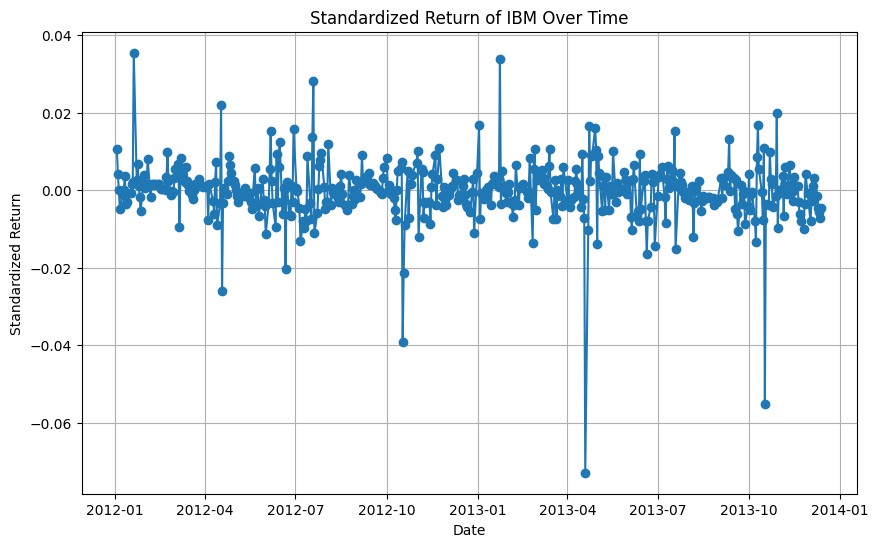

In [9]:


# Plotting standardized return over time
plt.figure(figsize=(10, 6))
plt.plot(ibm['date'], ibm['RET'], marker='o')
plt.title('Standardized Return of IBM Over Time')
plt.xlabel('Date')
plt.ylabel('Standardized Return')
plt.grid(True)
plt.show()

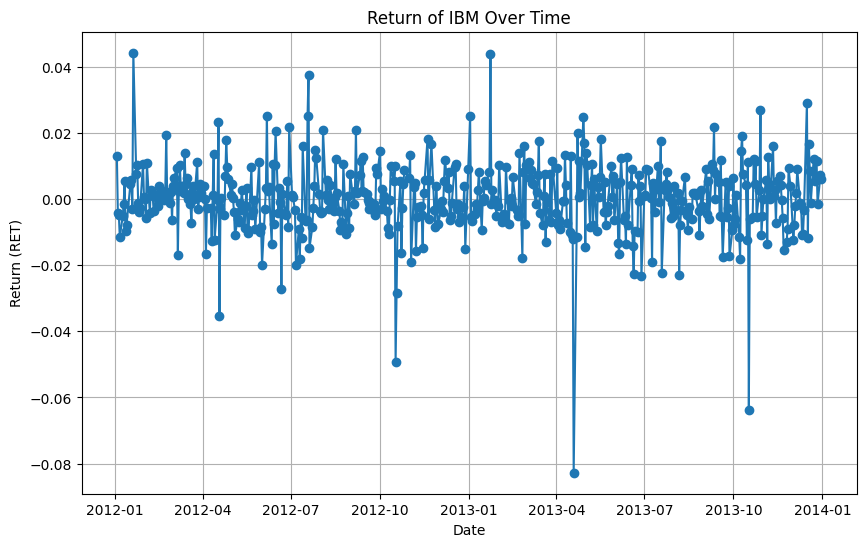

In [18]:
ibm_subset = df[df['TICKER'] == 'IBM']
ibm_subset=ibm_subset[ibm_subset['date']>=datetime(2012,1,1)]
ibm_subset=ibm_subset[ibm_subset['date']<=datetime(2014,1,1)]
# Plotting RET vs. time for IBM
plt.figure(figsize=(10, 6))
plt.plot(ibm_subset['date'], ibm_subset['RET'], marker='o')
plt.title('Return of IBM Over Time')
plt.xlabel('Date')
plt.ylabel('Return (RET)')
plt.grid(True)
plt.show()

In [7]:
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
from tqdm import tqdm
import numpy as np

# Calculate class weights

# clf = RandomForestClassifier(n_estimators=1000, max_depth=20, random_state=42)


# reg = RandomForestRegressor(n_estimators=1000, max_depth=20, random_state=42)


In [8]:
study_periods[0][1]

,date,TICKER,RET,MktCap,rolling_mean,standardized_return,target
2844220,2012-08-03,BAP,0.011320,9120670.35,0.011320,2.349795,1
2844221,2012-08-03,CMI,0.038389,19026513.00,0.038389,9.059523,1
2844222,2012-08-03,ETR,0.012251,12881230.89,0.012251,2.580567,1
2844223,2012-08-03,MSI,-0.015687,13473560.36,-0.015687,-4.344564,0
2844224,2012-08-03,KGC,0.033467,8795249.32,0.033467,7.839482,1
...,...,...,...,...,...,...,...
2928998,2013-04-09,IWF,0.003385,19342127.50,0.000784,-0.261884,1
2928999,2013-04-09,FIS,-0.001788,11511575.01,0.001559,-0.069812,1
2929000,2013-04-09,CMCSA,-0.008407,85432675.20,0.001272,-0.140804,1
2929001,2013-04-09,FE,0.006982,18698437.36,-0.000315,-0.534246,1


In [9]:
#EDIT CODE TO DO REGRESSION or CLASSIFICATION
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def train_and_evaluate_rf(study_periods):
    in_sample_accuracies = []
    out_of_sample_accuracies = []

    for train_df, test_df in tqdm(study_periods):
        X_train = train_df[['standardized_return']]
        y_train = train_df['target']
        X_test = test_df[['standardized_return']]
        y_test = test_df['target']

        # Initialize the RandomForestClassifier
        clf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)

        # Train the classifier
        clf.fit(X_train, y_train)

        # Predict on both train and test data
        train_preds = clf.predict(X_train)
        test_preds = clf.predict(X_test)

        # Calculate accuracies
        train_accuracy = accuracy_score(y_train, train_preds)
        test_accuracy = accuracy_score(y_test, test_preds)

        in_sample_accuracies.append(train_accuracy)
        out_of_sample_accuracies.append(test_accuracy)

    # Return the average accuracies
    avg_train_accuracy = sum(in_sample_accuracies) / len(in_sample_accuracies)
    avg_test_accuracy = sum(out_of_sample_accuracies) / len(out_of_sample_accuracies)

    return avg_train_accuracy, avg_test_accuracy

# Example Usage
# Assuming study_periods contains the train-test split dataframes
avg_train_accuracy, avg_test_accuracy = train_and_evaluate_rf(study_periods)
print("Average Train Accuracy:", avg_train_accuracy)
print("Average Test Accuracy:", avg_test_accuracy)


100%|██████████| 4/4 [01:37<00:00, 24.29s/it]

Average Train Accuracy: 0.696364365934537
Average Test Accuracy: 0.45250459356828165


In [ ]:
import pandas as pd

def validate_study_periods(study_periods):
    validation_results = []

    for i, (train_df, test_df) in enumerate(study_periods):
        result = {'Period': i+1, 'Issues': []}

        # Check for missing values
        if train_df.isnull().any().any() or test_df.isnull().any().any():
            result['Issues'].append("Missing values detected")

        # Inspect for outliers in key columns (customize as per your data)
        for column in ['RET', 'rolling_mean', 'standardized_return']:
            if train_df[column].abs().max() > 100 or test_df[column].abs().max() > 100:  # Adjust threshold as needed
                result['Issues'].append(f"Potential outliers in {column}")

        # Verify data types
        if not pd.api.types.is_datetime64_any_dtype(train_df['date']) or not pd.api.types.is_datetime64_any_dtype(test_df['date']):
            result['Issues'].append("Incorrect date data type")

        # Ensure chronological order
        if not (train_df['date'].is_monotonic_increasing and test_df['date'].is_monotonic_increasing):
            result['Issues'].append("Data not in chronological order")

        # Validate no overlap between training and test sets
        if train_df['date'].max() >= test_df['date'].min():
            result['Issues'].append("Overlap between training and test sets")

        validation_results.append(result)

    return validation_results

# Example usage
validation_results = validate_study_periods(study_periods)
for result in validation_results:
    print(f"Period {result['Period']}: {'No issues' if not result['Issues'] else ', '.join(result['Issues'])}")


In [ ]:
# # Creating separate DataFrames for in-sample and out-of-sample portfolios
# in_sample_long_portfolios = pd.DataFrame()
# out_of_sample_long_portfolios = pd.DataFrame()

# in_sample_short_portfolios = pd.DataFrame()
# out_of_sample_short_portfolios = pd.DataFrame()

# # Assuming study_periods contains the train-test split dataframes
# for train_df, test_df in tqdm(study_periods):
#     X_train = train_df[['standardized_return']]
#     y_train = train_df['target']

#     X_test = test_df[['standardized_return']]
#     y_test = test_df['target']
#     # class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
#     # class_weights_dict = {0: class_weights[0], 1: class_weights[1] * 5}  # Increase the weight for class 1 as needed

#     # clf = RandomForestClassifier(n_estimators=1000, max_depth=20, random_state=42, class_weight=class_weights_dict)

#     # Train the classifier
#     # clf.fit(X_train, y_train)
#     reg.fit(X_train, y_train)
#     # Predict on both train and test data
#     # train_probs = clf.predict_proba(X_train)[:, 1]
#     # test_probs = clf.predict_proba(X_test)[:, 1]
#     train_preds = reg.predict(X_train)
#     test_preds = reg.predict(X_test)


#     # Assign predicted probabilities back to train and test dataframes
#     # train_df['predicted_prob'] = train_probs
#     # test_df['predicted_prob'] = test_probs
#     train_df['predicted_prob'] = train_preds
#     test_df['predicted_prob'] = test_preds

#     k = 10

#     # Iterate over unique dates in train_df for in-sample data
#     for date in train_df['date'].unique():
#         date_data = train_df[train_df['date'] == date]
#         sorted_data = date_data.sort_values(by='predicted_prob', ascending=False)

#         long_tickers = sorted_data.head(k)[['date', 'TICKER', 'predicted_prob']]
#         short_tickers = sorted_data.tail(k)[['date', 'TICKER', 'predicted_prob']]

#         in_sample_long_portfolios = pd.concat([in_sample_long_portfolios, long_tickers])
#         in_sample_short_portfolios = pd.concat([in_sample_short_portfolios, short_tickers])

#     # Iterate over unique dates in test_df for out-of-sample data
#     for date in test_df['date'].unique():
#         date_data = test_df[test_df['date'] == date]
#         sorted_data = date_data.sort_values(by='predicted_prob', ascending=False)

#         long_tickers = sorted_data.head(k)[['date', 'TICKER', 'predicted_prob']]
#         short_tickers = sorted_data.tail(k)[['date', 'TICKER', 'predicted_prob']]

#         out_of_sample_long_portfolios = pd.concat([out_of_sample_long_portfolios, long_tickers])
#         out_of_sample_short_portfolios = pd.concat([out_of_sample_short_portfolios, short_tickers])


# Accuracy

# Portfolios

In [ ]:
#pickle the porfolios and returns df
in_sample_long_portfolios.to_csv('../data/rf_results/in_sample_long_portfolios.csv')
in_sample_short_portfolios.to_csv('../data/rf_results/in_sample_short_portfolios.csv')
out_of_sample_long_portfolios.to_csv('../data/rf_results/out_of_sample_long_portfolios.csv')
out_of_sample_short_portfolios.to_csv('../data/rf_results/out_of_sample_short_portfolios.csv')


# Raw Returns

In [ ]:
import pandas as pd
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Creating separate DataFrames for in-sample and out-of-sample portfolios
in_sample_long_portfolios = pd.DataFrame()
out_of_sample_long_portfolios = pd.DataFrame()

in_sample_short_portfolios = pd.DataFrame()
out_of_sample_short_portfolios = pd.DataFrame()

# Assuming study_periods contains the train-test split dataframes
for train_df, test_df in tqdm(study_periods):
    X_train = train_df[['standardized_return']]
    y_train = train_df['RET']  # Change to 'RET' to predict actual returns

    X_test = test_df[['standardized_return']]
    y_test = test_df['RET']  # Change to 'RET' to predict actual returns

    regr = RandomForestRegressor(n_estimators=1000, max_depth=20, random_state=42)

    # Train the regressor
    regr.fit(X_train, y_train)

    # Predict on both train and test data
    train_preds = regr.predict(X_train)
    test_preds = regr.predict(X_test)

    # Assign predicted returns back to train and test dataframes
    train_df['predicted_return'] = train_preds
    test_df['predicted_return'] = test_preds

    k = 10  # Number of positions to take for both long and short portfolios

    # Iterate over unique dates in train_df for in-sample data
    for date in train_df['date'].unique():
        date_data = train_df[train_df['date'] == date]

        # Select the top k stocks with the highest predicted return
        long_tickers = date_data.nlargest(k, 'predicted_return')[['date', 'TICKER', 'predicted_return']]
        # Select the bottom k stocks with the lowest predicted return
        short_tickers = date_data.nsmallest(k, 'predicted_return')[['date', 'TICKER', 'predicted_return']]

        in_sample_long_portfolios = pd.concat([in_sample_long_portfolios, long_tickers])
        in_sample_short_portfolios = pd.concat([in_sample_short_portfolios, short_tickers])

    # Iterate over unique dates in test_df for out-of-sample data
    for date in test_df['date'].unique():
        date_data = test_df[test_df['date'] == date]

        # Select the top k stocks with the highest predicted return
        long_tickers = date_data.nlargest(k, 'predicted_return')[['date', 'TICKER', 'predicted_return']]
        # Select the bottom k stocks with the lowest predicted return
        short_tickers = date_data.nsmallest(k, 'predicted_return')[['date', 'TICKER', 'predicted_return']]

        out_of_sample_long_portfolios = pd.concat([out_of_sample_long_portfolios, long_tickers])
        out_of_sample_short_portfolios = pd.concat([out_of_sample_short_portfolios, short_tickers])


In [ ]:
#Optional parameter target_type: 'cross_sectional_median(default)','buckets(10 buckets)','raw_returns'.
study_periods=create_study_periods(df,n_periods=23,window_size=240,trade_size=250,train_size=750,forward_roll=250,start_date=datetime(1990,1,1),end_date=datetime(2015,12,31))